<a href="https://colab.research.google.com/github/FelipeTavares7/data_science/blob/main/Modelo_de_Clustering_para_an%C3%A1lise_de_m%C3%A9tricas_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Understanding**

**Projeto: Criação um modelo de
análise das métricas RFM.**

**Objetivo do Negócio:**
> A empresa de e-commerce deseja personalizar suas campanhas de marketing segmentando os clientes com base em seu comportamento de compra.

**Objetivo dos Dados:**
> Agrupar os clientes em clusters com base em seu comportamento de compra para identificar padrões e características comuns.

**Critérios de Sucesso:**
> * Identificação de clusters significativos e distintos de clientes.
> * Insights gerados para personalização efetiva das campanhas de marketing.

**Recursos Disponíveis:**
> Base de dados em CSV contendo informações sobre clientes, produtos e transações entre 2010 e 2011.

**Riscos e Limitações:**
>* Os dados podem estar incompletos ou inconsistentes;
* A segmentação pode não capturar completamente a diversidade do comportamento do cliente.

**Visão Geral do Processo:**
1. **Entendimento do Negócio:** Compreender as necessidades da empresa e como os dados podem ser usados para atender a essas necessidades.
2. **Entendimento dos Dados:** Explorar a base de dados para compreender sua estrutura, qualidade e potencial para análise.
3. **Preparação dos Dados:** Limpar, transformar e preparar os dados para análise.
4. **Modelagem:** Aplicar técnicas de agrupamento (clustering) para identificar padrões nos dados.
5. **Avaliação:** Avaliar a qualidade dos clusters gerados e sua utilidade para os objetivos do negócio.
6. **Implantação:** Gerar insights e recomendações para a empresa com base nos clusters identificados.



---




# **Setup**

In [ ]:
# -- Bíbliotecas -- #

# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.cluster import KMeans
from yellowbrick.cluster import kelbow_visualizer
from sklearn.preprocessing import RobustScaler



---



# **Data Understanding**

In [ ]:
# Carregando os Dados
df = pd.read_csv('data.csv', encoding='ISO-8859-1', delimiter=',')

In [ ]:
# Visualizando os primeiros registros do Dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Informações sobre o DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# Verificando a quantidade de valores nulos em cada feature
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# Verificando número de registros duplicados
print(f'Quantidade de registros duplicados: {df.duplicated(keep="first").sum()}')

Quantidade de registros duplicados: 5268


In [ ]:
# Verificando pedidos cancelados ('InvoiceNo' começa com C)
print(f"Quantidade de pedidos cancelados: {len(df[df['InvoiceNo'].str.startswith('C')])}")

Quantidade de pedidos cancelados: 9288


- O Dataframe possui 541909 registros e 8 features. Sendo as features:
  - `InvoiceNo` - Código da fatura;
  - `StockCode` - Código de estoque do produto;
  - `Description` - Descrição do produto;
  - `Quantity` - Quantidade do produto;
  - `InvoiceDate` - Data do faturamento;
  - `UnitPrice` - Preço unitário do produto;
  - `CustomerID` - Código de identificação do cliente;
  - `Country` - País da compra.
- Há dados nulos presentes no conjunto de dados em `Description`(1454) e `CustomerID`(135080).
- Há 5268 registros duplicados.
- 9288 pedidos foram cancelados.


---



# **Data Preparation**

## Duplicate records

In [ ]:
# Dropando registros duplicados
df = df.drop_duplicates(keep='first')

## Null data

In [ ]:
# Removendo linhas onde CustomerID é nulo
df = df.dropna(subset=['CustomerID'])

A exclusão dos registros com valores nulos na feature `CustomerID` é justificada pelo papel fundamental desse código no cálculo das métricas RFM.

In [ ]:
# Verificando se ainda existe algum registro nulo após exclusão acima
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Durante a etapa de Data Understanding, foi identificado que alguns registros estavam nulos na feature `Description`. No entanto, ao remover os registros nulos da feature `CustomerID`, esses registros também foram excluídos, sem necessidades de tratamentos adicionais em relação a isso.

## `Quantity` < 1

Quantidades menores que 1 serão desconsideradas.

In [ ]:
# Removendo registros de 'Quantity' é menor que 1
df = df[(df['Quantity'] >= 1)]

## `UnitPrice` <= 0

Preços zerados ou negativos serão desconsiderados.

In [ ]:
# Removendo registros de 'UnitPrice' é menor ou igual a 0
df = df[(df['UnitPrice'] > 0)]

## Feature types

In [ ]:
# Visualizando os tipos
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

### `InvoiceDate`

In [ ]:
# Visualizando o formato da data
df['InvoiceDate'].head()

0    12/1/2010 8:26
1    12/1/2010 8:26
2    12/1/2010 8:26
3    12/1/2010 8:26
4    12/1/2010 8:26
Name: InvoiceDate, dtype: object

In [ ]:
# Corrigindo o tipo da coluna 'InvoiceDate'
df = df.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [ ]:
# Visualizando correção
df['InvoiceDate'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

## Canceled Orders

In [ ]:
# Verificando pedidos cancelados ('InvoiceNo' começa com C)
print(f"Quantidade de pedidos cancelados: {len(df[df['InvoiceNo'].str.startswith('C')])}")

Quantidade de pedidos cancelados: 0


Os pedidos cancelados foram removidos durante as etapas anteriores.

## Outliers

Considerado outliers:


*   `Quantity` maior que 10000;
*   `UnitPrice` maior que 5000.

In [ ]:
# Removendo outliers em 'Quantity' e 'UnitPrice'
df = df.query('Quantity <= 10000 and UnitPrice <= 5000')

## Creating `TotalPrice` column

`Quantity` * `UnitPrice`

In [ ]:
df = df.copy()
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Last date

In [ ]:
# Calculando a data da última compra
last_date = df['InvoiceDate'].max()



---



# **RFM**

## Calculation of RFM

- **R** é a recência, diferença em dias da última compra do cliente e da última
compra disponível no conjunto de dados;
- **F** é a frequência, ou seja, a quantidade de compras feitas pelo cliente;
- **M** é o valor financeiro do quanto o cliente já comprou.

In [ ]:
# Agrupando os dados por cliente e pedido para obter a data e o preço total do pedido
agg_customer_invoice = df.groupby(['CustomerID', 'InvoiceNo']).agg({
    'InvoiceDate': 'max',
    'TotalPrice': 'sum'
})

agg_customer_invoice.head()

InvoiceDate  TotalPrice
CustomerID InvoiceNo                                
12347.0    537626    2010-12-07 14:57:00      711.79
           542237    2011-01-26 14:30:00      475.39
           549222    2011-04-07 10:43:00      636.25
           556201    2011-06-09 13:01:00      382.52
           562032    2011-08-02 08:48:00      584.91

In [ ]:
rfm = agg_customer_invoice.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (last_date - date.max()).days, # Calculando a recência (R)
    'TotalPrice': lambda price: price.sum() # Calculando o valor das compras (M) com 2 casas decimais
})

In [ ]:
#  Calculando a frequência (F)
freq_customer = df.groupby('CustomerID')['InvoiceNo'].nunique()

rfm['Frequency'] = freq_customer

In [ ]:
rfm.head()

,InvoiceDate,TotalPrice,Frequency
CustomerID,,,
12347.0,1,4310.00,7
12348.0,74,1797.24,4
12349.0,18,1757.55,1
12350.0,309,334.40,1
12352.0,35,2506.04,8


In [ ]:
# Renomeando as colunas para RFM
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'TotalPrice': 'MonetaryValue'
}, inplace=True)

# Reordenando as colunas para exibir na ordem RFM
rfm = rfm[['Recency', 'Frequency', 'MonetaryValue']]

# Colocando CustomerID como índice
rfm.reset_index(inplace=True)

# Visualizando o resultado
rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12347.0,1,7,4310.00
1,12348.0,74,4,1797.24
2,12349.0,18,1,1757.55
3,12350.0,309,1,334.40
4,12352.0,35,8,2506.04


## Analysis of RFM Features

### Distributions

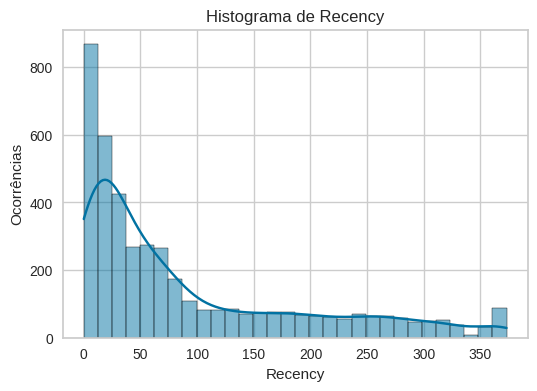

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(data=rfm, x='Recency', bins=30, kde=True)
plt.title('Histograma de Recency')
plt.xlabel('Recency')
plt.ylabel('Ocorrências')
plt.show()

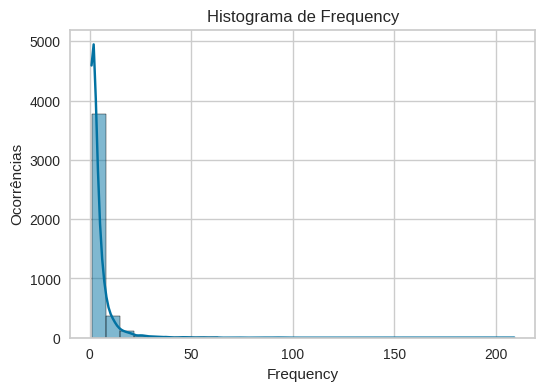

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(data=rfm, x='Frequency', bins=30, kde=True)
plt.title('Histograma de Frequency')
plt.xlabel('Frequency')
plt.ylabel('Ocorrências')
plt.show()

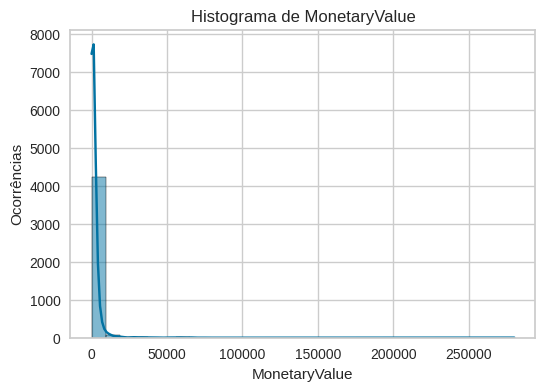

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(data=rfm, x='MonetaryValue', bins=30, kde=True)
plt.title('Histograma de MonetaryValue')
plt.xlabel('MonetaryValue')
plt.ylabel('Ocorrências')
plt.show()

### Correlation

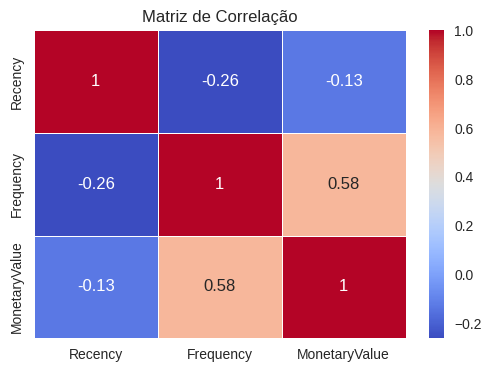

In [ ]:
corr_matrix = rfm[['Recency', 'Frequency', 'MonetaryValue']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

Existe uma correlação moderada (0.58) entre **Frequency** e **MonetaryValue**. Esta correlação é esperada, uma vez que os clientes tendem a gastar mais quando fazem compras com maior frequência.

### Box Plots

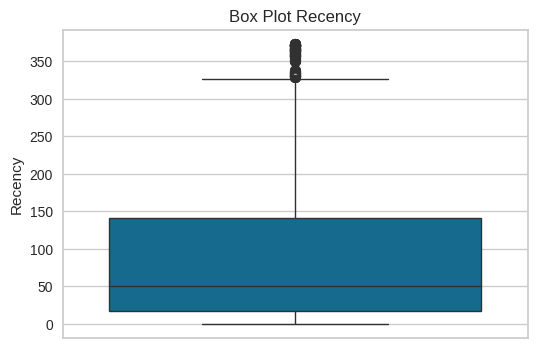

In [ ]:
# Recency
plt.figure(figsize=(6, 4))
sns.boxplot(data = rfm, y='Recency')
plt.title('Box Plot Recency')
plt.ylabel('Recency')
plt.show()

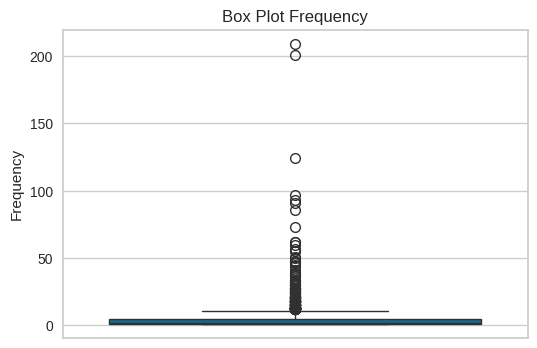

In [ ]:
# Frequency
plt.figure(figsize=(6, 4))
sns.boxplot(data = rfm, y='Frequency')
plt.title('Box Plot Frequency')
plt.ylabel('Frequency')
plt.show()

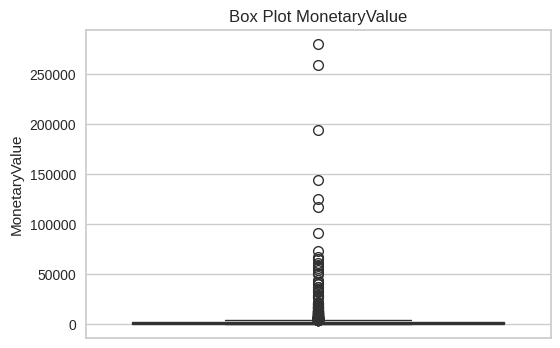

In [ ]:
# MonetaryValue
plt.figure(figsize=(6, 4))
sns.boxplot(data = rfm, y='MonetaryValue')
plt.title('Box Plot MonetaryValue')
plt.ylabel('MonetaryValue')
plt.show()

Há vários outiliers nas features e podem dificultar as segmentações.

## RFM Scores

Existem várias abordagens para a segmentação RFM. Utilizarei a estrutura RFM, atribuindo pontuações de 1 a 3 para cada fator (Recency, Frequency, Monetary Value). O valor 3 representa a melhor/maior pontuação, enquanto o valor 1 representa a pior/menor pontuação.

A pontuação RFM final é calculada simplesmente combinando as pontuações individuais de RFM. Os segmentos RFM serão definidos usando a tabela abaixo.

In [ ]:
# Criando o dicionário
table_scores = {
    'Nome_Segmento': ['Campeões', 'Fidelizados', 'Recentes', 'Precisa de Atenção', 'Em Risco', 'Inativos'],
    'Pontuação_RFM': ['333, 332, 323', '321, 322, 331, 232, 233', '312, 313, 311, 222, 223', '213, 221, 123, 132, 133', '231, 212, 122, 131, 211', '111, 112, 113, 121'],
    'Descrição': ['Os melhores clientes', 'Clientes valiosos e engajados', 'Clientes recentes', 'Cliente valioso que não comprou recentemente', 'Cliente que não comprou recentemente e/ou tende a gastar menos no total', 'Cliente inativo']
}

# Transformando em df Pandas
df_table_scores = pd.DataFrame(table_scores)

# Mostrar todo conteúdo das linhas
pd.set_option('display.max_colwidth', None)

# Visualizando
df_table_scores

,Nome_Segmento,Pontuação_RFM,Descrição
0,Campeões,"333, 332, 323",Os melhores clientes
1,Fidelizados,"321, 322, 331, 232, 233",Clientes valiosos e engajados
2,Recentes,"312, 313, 311, 222, 223",Clientes recentes
3,Precisa de Atenção,"213, 221, 123, 132, 133",Cliente valioso que não comprou recentemente
4,Em Risco,"231, 212, 122, 131, 211",Cliente que não comprou recentemente e/ou tende a gastar menos no total
5,Inativos,"111, 112, 113, 121",Cliente inativo


In [ ]:
rfm["Recency_Score"]  = pd.qcut(rfm['Recency'], 3, [3, 2, 1])
rfm["Frequency_Score"]  = pd.qcut(rfm['Frequency'].rank(method="first"), 3, [1, 2, 3])
rfm["Monetary_Score"]  = pd.qcut(rfm['MonetaryValue'], 3, [1, 2, 3])
rfm["RFM_Score"] = rfm["Recency_Score"].astype(str) + rfm["Frequency_Score"].astype(str) + rfm["Monetary_Score"].astype(str)
rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
0,12347.0,1,7,4310.00,3,3,3,333
1,12348.0,74,4,1797.24,2,2,3,223
2,12349.0,18,1,1757.55,3,1,3,313
3,12350.0,309,1,334.40,1,1,1,111
4,12352.0,35,8,2506.04,2,3,3,233


## RFM Segmentation

In [ ]:
# Criando a feature 'Segment" de acordo com o RFM_Score
def segment_customers(rfm_score):
    if rfm_score in ['333', '332', '323']:
        return 'Campeões'
    elif rfm_score in ['321', '322', '331', '232', '233']:
        return 'Fidelizados'
    elif rfm_score in ['312', '313', '311', '222', '223']:
        return 'Recentes'
    elif rfm_score in ['213', '221', '123', '132', '133']:
        return 'Precisa de Atenção'
    elif rfm_score in ['231', '212', '122', '131', '211']:
        return 'Em Risco'
    elif rfm_score in ['111', '112', '113', '121']:
        return 'Inativos'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customers)

## RFM Segment Analysis

In [ ]:
# Contagem de clientes por segmento
rfm.reset_index(inplace=True)
rfm.groupby('Segment').agg({'CustomerID':'count'})

,CustomerID
Segment,
Campeões,948
Em Risco,710
Fidelizados,780
Inativos,975
Precisa de Atenção,338
Recentes,586


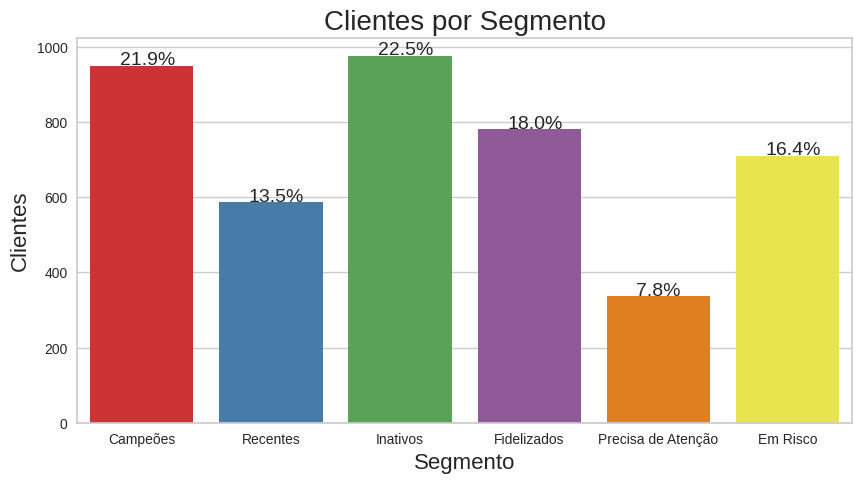

In [ ]:
# Visualizando gráfico
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=rfm,
                   x='Segment',
                   hue='Segment',
                   palette='Set1')
total = len(rfm.Segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size=14)
plt.title('Clientes por Segmento', size=20)
plt.xlabel('Segmento', size=16)
plt.ylabel('Clientes', size=16)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show();



---



# **K-Means Clustering**

O algoritmo de clustering K-Means é um algoritmo de aprendizado não supervisionado muito comum. Ele é escalável para conjuntos de dados muito grandes e tende a funcionar bem na prática. O K-Means tenta encontrar a melhor maneira de agrupar pontos de dados em k grupos diferentes, onde k é um parâmetro fornecido ao algoritmo.

## Features selection

**Features Selecionadas:**

`Recency`: indica o quão recentemente um cliente fez uma compra e pode refletir o engajamento atual do cliente com a loja.

`Frequency`: indica com que frequência um cliente faz compras e pode indicar clientes regulares ou esporádicos.

`MonetaryValue`: indica o valor das compras de um cliente e pode indicar clientes de alto ou baixo valor.


In [ ]:
# Criando um novo df com as features selecionadas
df_selected = rfm[['Recency', 'Frequency', 'MonetaryValue']]

# Visualizando
df_selected.head()

,Recency,Frequency,MonetaryValue
0,1,7,4310.00
1,74,4,1797.24
2,18,1,1757.55
3,309,1,334.40
4,35,8,2506.04


In [ ]:
# Verificando os tipos
df_selected.dtypes

Recency            int64
Frequency          int64
MonetaryValue    float64
dtype: object

## Log Transformation


As distribuições de Recency, Frequency e MonetaryValue são assimétricas distorcidas à direita. O clustering K-means funciona bem com distribuições simétricas das variáveis.

In [ ]:
# Aplicando o Log Transform
rfm_log = df_selected.copy()
for col in df_selected:
    rfm_log[col] = np.log1p(rfm[col])

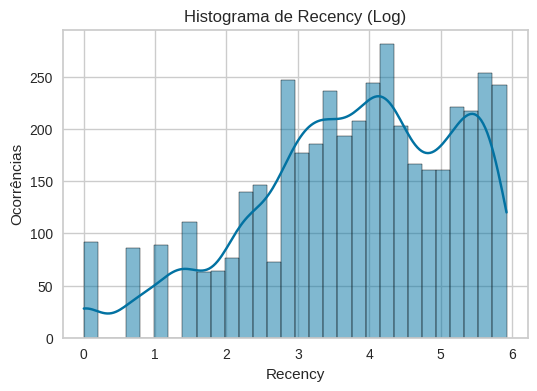

In [ ]:
# Verificando distribuição de Recency após o Log Transform
plt.figure(figsize=(6, 4))
sns.histplot(data=rfm_log, x='Recency', bins=30, kde=True)
plt.title('Histograma de Recency (Log)')
plt.xlabel('Recency')
plt.ylabel('Ocorrências')
plt.show()

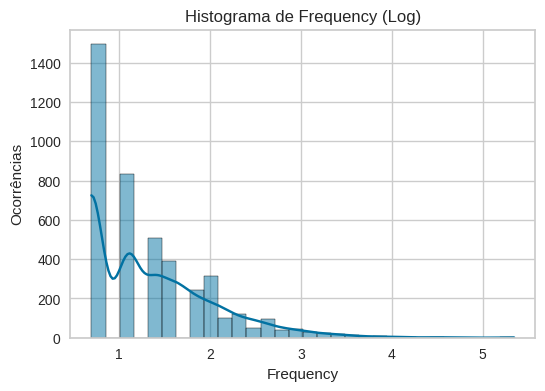

In [ ]:
# Verificando distribuição de Frequency após o Log Transform
plt.figure(figsize=(6, 4))
sns.histplot(data=rfm_log, x='Frequency', bins=30, kde=True)
plt.title('Histograma de Frequency (Log)')
plt.xlabel('Frequency')
plt.ylabel('Ocorrências')
plt.show()

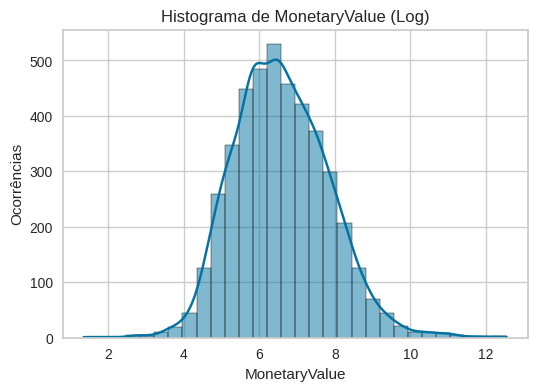

In [ ]:
# Verificando distribuição de MonetaryValue após o Log Transform
plt.figure(figsize=(6, 4))
sns.histplot(data=rfm_log, x='MonetaryValue', bins=30, kde=True)
plt.title('Histograma de MonetaryValue (Log)')
plt.xlabel('MonetaryValue')
plt.ylabel('Ocorrências')
plt.show()

## Normalization

In [ ]:
# Inicializando o RobustScaler
scaler = RobustScaler()

rfm_scaled = rfm_log.copy()

# Normalizando as features numéricas
rfm_scaled.loc[:, ['Recency', 'Frequency', 'MonetaryValue']] = scaler.fit_transform(rfm_scaled[['Recency', 'Frequency', 'MonetaryValue']])

## Numbers of Clusters (k)

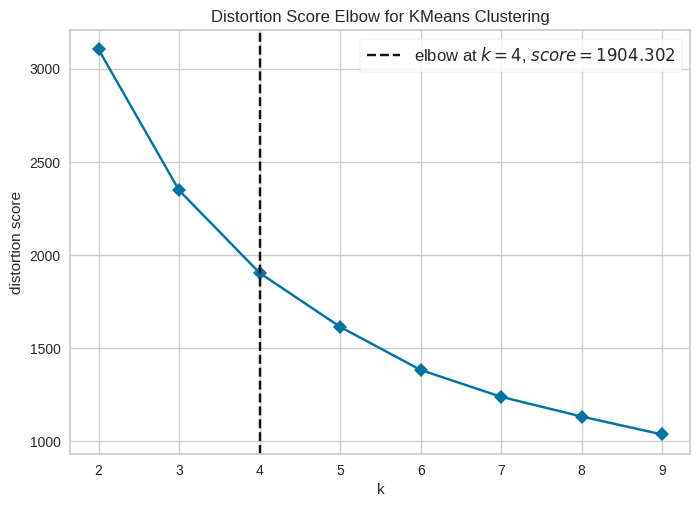

In [ ]:
# Procurando o melhor K
kelbow_visualizer(model=KMeans(n_init=10), X=rfm_scaled, k=(2,10), timings=False);

Foi indicado pelo Método de Elbow 4 clusters

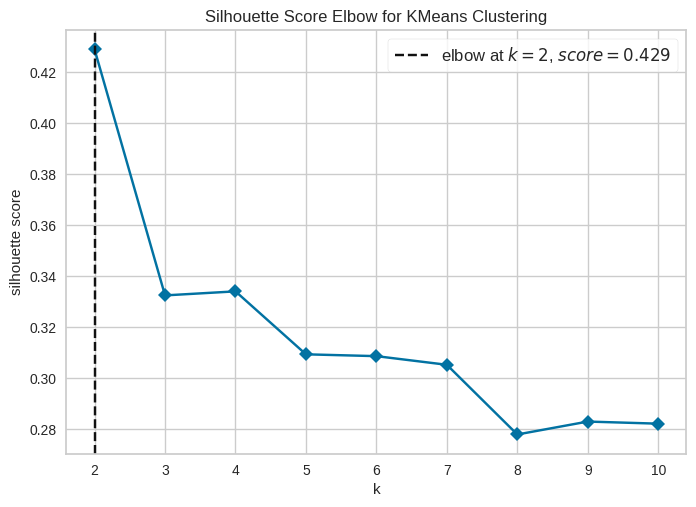

In [ ]:
kelbow_visualizer(model=KMeans(n_init=10), X=rfm_scaled, timings=False, metric='silhouette');

Já pela métrica de Silhouette Score o numéro de clusters indicado foram 2. Usaremos 4 que foi a segunda maior pontuação.

## Model

In [ ]:
# Criando e treinando o modelo com k=4
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

## Evaluating Clusters

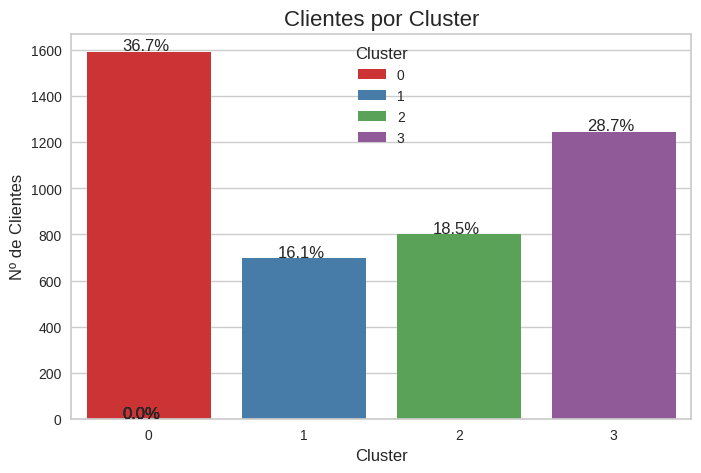

In [ ]:
# Visualizando Clientes por Cluster
plt.figure(figsize = (8, 5))
ax = sns.countplot(data = rfm,
                   x = 'Cluster',
                   hue='Cluster',
                   palette='Set1')
total = len(rfm.Cluster)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 12)
plt.title('Clientes por Cluster', size = 16)
plt.xlabel('Cluster', size = 12)
plt.ylabel('Nº de Clientes', size = 12)
plt.show();

Recency e Frequency por Cluster

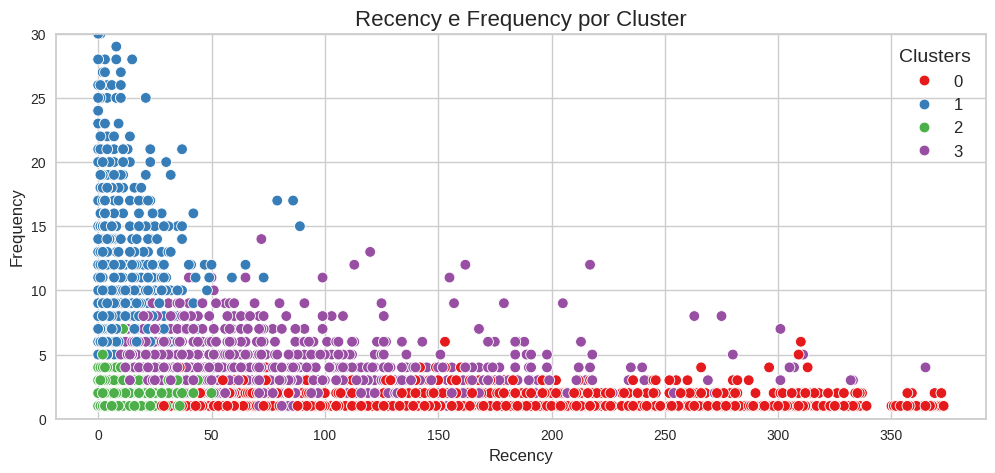

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm, x="Recency", y="Frequency", hue="Cluster", palette='Set1', s=60
)
plt.title("Recency e Frequency por Cluster", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Clusters", title_fontsize=14)
plt.ylim(0, 30)
plt.show();

Recency e MonetaryValue por Cluster

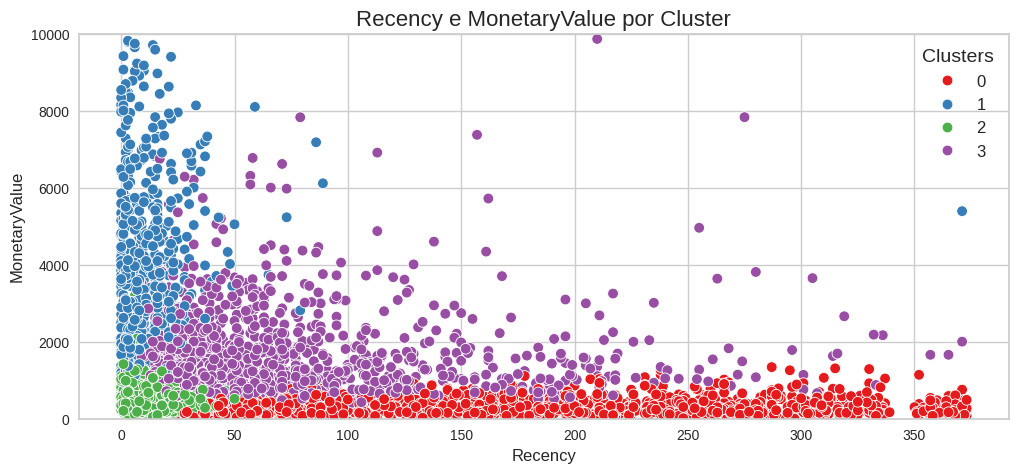

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm, x="Recency", y="MonetaryValue", hue="Cluster", palette='Set1', s=60
)
plt.title("Recency e MonetaryValue por Cluster", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("MonetaryValue", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Clusters", title_fontsize=14)
plt.ylim(0, 10000)
plt.show();

MonetaryValue e Frequency por Cluster

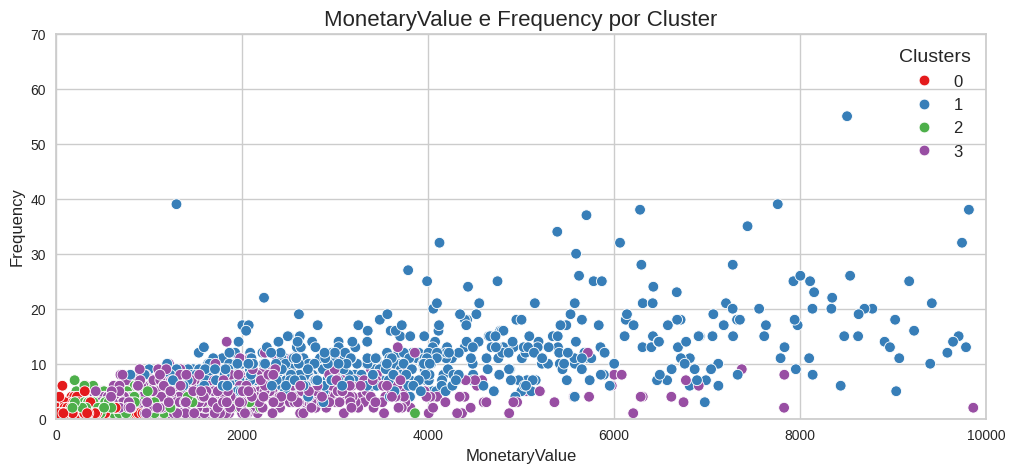

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm, x="MonetaryValue", y="Frequency", hue="Cluster", palette='Set1', s=60
)
plt.title("MonetaryValue e Frequency por Cluster", size=16)
plt.xlabel("MonetaryValue", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Clusters", title_fontsize=14)
plt.xlim(0, 10000)
plt.ylim(0, 70)
plt.show();

# **Mapping of Clusters and RFM Segments**

In [ ]:
rfm_cl_seg = rfm[['Cluster', 'Segment', 'CustomerID']].groupby(['Cluster', 'Segment']).agg({'count'})
rfm_cl_seg=rfm_cl_seg.reset_index()
rfm_cl_seg.head()

,Cluster,Segment,CustomerID
,,,count
0,0,Em Risco,526
1,0,Inativos,953
2,0,Precisa de Atenção,78
3,0,Recentes,35
4,1,Campeões,629


In [ ]:
# Cores para o gráfico de pizza
color_mapping = {
    'Campeões': 'forestgreen',
    'Fidelizados': 'lightseagreen',
    'Recentes': 'deepskyblue',
    'Precisa de Atenção': 'gold',
    'Em Risco': 'tomato',
    'Inativos': 'mediumpurple'
}

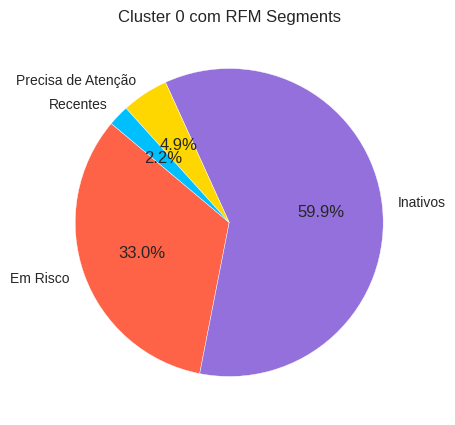

In [ ]:
# Cluster 0 com RFM Segments
rfm_cluster = rfm_cl_seg[rfm_cl_seg[('Cluster')] == 0]
plt.figure(figsize=(5, 5))
colors = sns.color_palette('hls')
plt.pie(rfm_cluster[('CustomerID', 'count')],
        labels=rfm_cluster['Segment'],
        autopct='%1.1f%%', startangle=140,
        colors=rfm_cluster['Segment'].map(color_mapping),
        wedgeprops=dict(edgecolor='white'))
plt.title('Cluster 0 com RFM Segments')
plt.show();

Cluster 0 predomina os clientes Em Risco e Inativos.

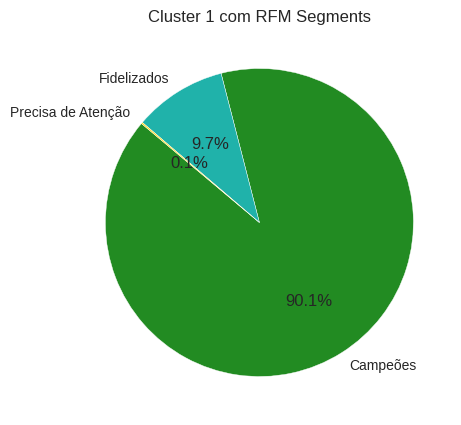

In [ ]:
# Cluster 1 com RFM Segments
rfm_cluster = rfm_cl_seg[rfm_cl_seg[('Cluster')] == 1]
plt.figure(figsize=(5, 5))
plt.pie(rfm_cluster[('CustomerID', 'count')],
        labels=rfm_cluster[('Segment')],
        autopct='%1.1f%%', startangle=140,
        colors=rfm_cluster['Segment'].map(color_mapping),
        wedgeprops=dict(edgecolor='white'))
plt.title('Cluster 1 com RFM Segments')
plt.show()

Cluster 1 predomina os melhores clientes e fidelizados.

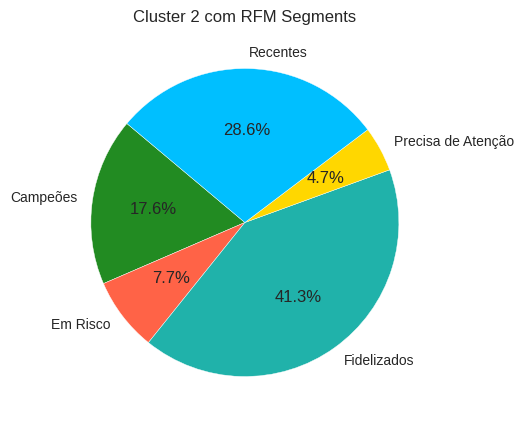

In [ ]:
# Cluster 2 com RFM Segments
rfm_cluster = rfm_cl_seg[rfm_cl_seg[('Cluster')] == 2]
plt.figure(figsize=(5, 5))
plt.pie(rfm_cluster[('CustomerID', 'count')],
        labels=rfm_cluster[('Segment')],
        autopct='%1.1f%%', startangle=140,
        colors=rfm_cluster['Segment'].map(color_mapping),
        wedgeprops=dict(edgecolor='white'))
plt.title('Cluster 2 com RFM Segments')
plt.show();

Cluster 2 está misturado, mas há predominância de Fidelizados e Recentes.

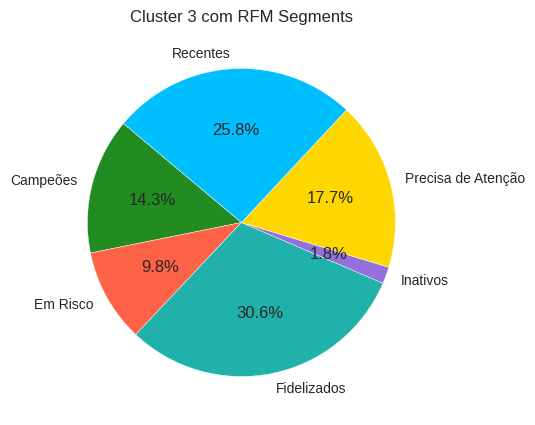

In [ ]:
# Cluster 3 com RFM Segments
rfm_cluster = rfm_cl_seg[rfm_cl_seg[('Cluster')] == 3]
plt.figure(figsize=(5, 5))
plt.pie(rfm_cluster[('CustomerID', 'count')],
        labels=rfm_cluster[('Segment')],
        autopct='%1.1f%%', startangle=140,
        colors=rfm_cluster['Segment'].map(color_mapping),
        wedgeprops=dict(edgecolor='white'))
plt.title('Cluster 3 com RFM Segments')
plt.show()

Cluster 3 já não há uma predominância.



---



# **Examples of Marketing Strategies**

**Campeões:**
1.   **Programa de Fidelidade Premium:** Ofereça um programa exclusivo de fidelidade com benefícios adicionais.
2.   **Convites VIP:** Envie convites exclusivos para eventos especiais ou pré-lançamentos de produtos.
3.   **Recompensas Personalizadas:** Crie recompensas personalizadas com base no histórico de compras e preferências.

**Fidelizados:**
1.   **Ofertas Especiais de Fidelização:** Ofereça descontos ou brindes exclusivos para clientes fiéis.
2.   **Upselling Inteligente:** Sugira produtos complementares ou atualizações para itens existentes.
3.   **Programas de Referência:** Incentive clientes leais a indicarem novos clientes com recompensas especiais.

**Recentes:**
1.   **Descontos para Próxima Compra:** Ofereça descontos para incentivar uma nova compra em um curto período.
2.   **Programas de Boas-Vindas:** Ofereça benefícios especiais para novos clientes recentes.
3.   **Comunicação Personalizada:** Envie e-mails ou mensagens personalizadas com recomendações de produtos com base em compras anteriores.

**Precisa de atenção:**
1.   **Campanhas de Reativação:** Crie campanhas específicas para reconquistar clientes que não compraram recentemente.
2.   **Ofertas Exclusivas:** Ofereça descontos exclusivos para clientes que demonstram interesse, mas não finalizaram a compra.
3.   **Suporte Personalizado:** Ofereça assistência personalizada para resolver quaisquer problemas ou dúvidas que os clientes possam ter.

**Em Risco:**
1.   **Ofertas de Recuperação:** Crie ofertas especiais para clientes em risco de cancelamento para incentivá-los a continuar comprando.
2.   **Feedback Ativo:** Peça feedback regularmente para identificar e resolver quaisquer problemas ou insatisfações.
3.   **Programas de Reengajamento:** Desenvolva programas especiais para reconquistar clientes em risco, como descontos especiais ou benefícios exclusivos.

**Inativos:**
1.   **Campanhas de Reconquista:** Crie campanhas específicas para trazer de volta clientes inativos.
2.   **Ofertas Irresistíveis:** Ofereça descontos ou promoções exclusivas para incentivar clientes inativos a fazer uma nova compra.
3.   **Reativação Personalizada:** Envie mensagens personalizadas com base no histórico de compras e interesses anteriores para reconquistar clientes.



---



# **References**

*   Documentações:
 *   https://pandas.pydata.org/docs/
 *   https://numpy.org/doc/
 *   https://matplotlib.org/stable/index.html
 *   https://seaborn.pydata.org/
 *   https://scikit-learn.org/stable/

*   Artigos RFM:
 *   https://connectif.ai/en/blog/what-are-rfm-scores-and-how-to-calculate-them/
 *   https://vidadeproduto.com.br/analise-rfm/

*   Notebooks Kaggle:
 *   https://www.kaggle.com/datasets/carrie1/ecommerce-data/code



---

